# Practical session on Machine-Learning for SEQUENTIAL data

We use a dataset containing inertial data timeseries from smartphones, recorded during several types of Human Activities.
The goal of the practical session is to experiment with one of the Machine-Learning techniques dedicated to SEQUENTIAL data: Recurrent Neural Networks (RNNs).


### Step 1: Data loading and formatting training and test data


In [1]:
import urllib.request

In [2]:
def unzip(filename, dest_path = None):
    # unzips a zip file in the folder of the notebook to the notebook
    with ZipFile(filename, 'r') as zObject: 
        # Extracting all the members of the zip  
        # into a specific location. a
        if dest_path is None:
            zObject.extractall(path=os.getcwd())
        else:
            zObject.extractall(path=dest_path)

In [3]:
import os
def download(url, filename):
    # download with check if file exists already
    if os.path.isfile(filename):
        return
    urllib.request.urlretrieve(url,filename)

In [4]:
from zipfile import ZipFile

In [ ]:
# Un-comment lines below only if executing on Google-COLAB
# ![[ -f UCI_HAR.zip ]] || wget --no-check-certificate https://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/Practical_sequentialData/UCI_HAR.zip
# ![[ -f "UCI_HAR" ]] || unzip UCI_HAR.zip

In [5]:
download('https://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/Practical_sequentialData/UCI_HAR.zip','UCI_HAR.zip')

In [6]:
unzip('UCI_HAR.zip')

In [ ]:
%%capture
!pip install numpy matplotlib pandas scikit-learn

In [24]:
# Import Necessary packages
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sklearn as sk
import sys
print('Your python version: {}'.format(sys.version_info.major))



#Path to the dataset folder
filepath='./UCI_HAR/'

groups=['train','test']

for group in groups:
    prefix=filepath+group+'/InertialSignals/'
    #Names of the inputs to the convolutional network
    #Two 3D raw features as inputs
    filenames = list()
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    loaded = []
    for name in filenames:
        file=open(prefix+name,'r')
        data = []
        for x in file:
            data.append([float(ts) for ts in x.split()])
        data = np.array(data)
        #Concatenation of all data concerning the two 3D raw features (body acceleration and angular velocity)
        loaded.append(data)

    #Name of the last 3D raw feature
    filenames_rest = ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']

    #First add the two previous 3D raw features
    loaded_all = []
    loaded_all += loaded

    #Then add the last 3D raw feature
    for name in filenames_rest:
        file=open(prefix+name,'r')
        data = []
        for x in file:
            data.append([float(ts) for ts in x.split()])
        data = np.array(data)
        #Concatenation of all data concerning all 3D raw features (body acceleration, angular velocity and total acceleration)
        loaded_all.append(data)

    # Stack group so that features are the 3rd dimension --> (samples, time steps, features)
    loaded = np.dstack(loaded)
    loaded_all = np.dstack(loaded_all)

    if group == 'train':
        #Training set for two 3D raw features
        tx_train = loaded
        #Training set for all 3D raw features
        tx_train_all = loaded_all
    if group =='test':
        #Testing set for two 3D raw features
        tx_test = loaded
        #Testing set for all 3D raw features
        tx_test_all = loaded_all

nbTimeseries = tx_train_all[0].shape[1]
lengthTimeseries = tx_train_all[0].shape[0]
print("Shape of examples:",tx_train_all[0].shape," (i.e. ",nbTimeseries," timeseries of length=",lengthTimeseries,")")

print("Training set shape:",tx_train_all.shape)
print("Test set shape:",tx_test_all.shape)

# Load labels
y_train = []
y_test = []
y_train_file = open(filepath+'train/y_train.txt', 'r')
y_test_file = open(filepath+'test/y_test.txt', 'r')
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
target_train = np.array(y_train) - 1
target_test = np.array(y_test) - 1

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

nbClasses = len(labels)
print("Number of classes =", nbClasses)
print("Activity classes (target values)",labels)

# Shuffle (because data is initially somewhat organized by class)
tx_train_all, target_train = sk.utils.shuffle(tx_train_all, target_train, random_state=0)
tx_test_all, target_test = sk.utils.shuffle(tx_test_all, target_test, random_state=0)


Your python version: 3
Shape of examples: (128, 9)  (i.e.  9  timeseries of length= 128 )
Training set shape: (7352, 128, 9)
Test set shape: (2947, 128, 9)
Number of classes = 6
Activity classes (target values) {1: 'WALKING', 2: 'WALKING UPSTAIRS', 3: 'WALKING DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


### Step2: Display some of the timeseries (sanity check)



 body acceleration [ba_x, ba_y, ba_z]=f(time) for example #0


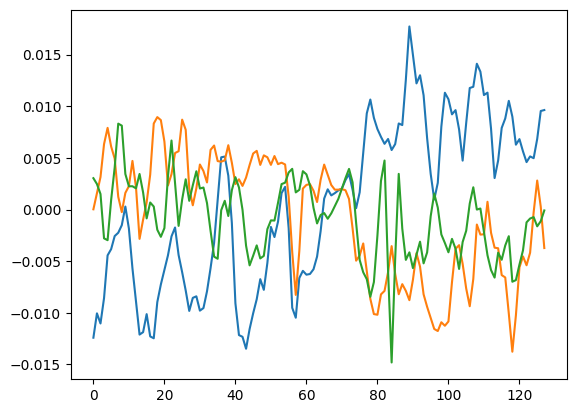


 body acceleration [ba_x, ba_y, ba_z]=f(time) for example #1


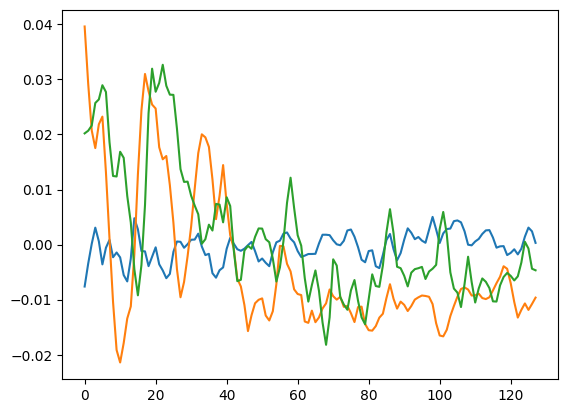


 body acceleration [ba_x, ba_y, ba_z]=f(time) for example #160


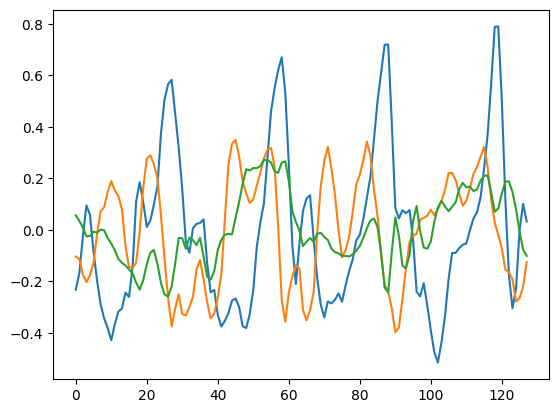


 body_gyro [bg_x, bg_y, bg_z]=f(time) for example #0


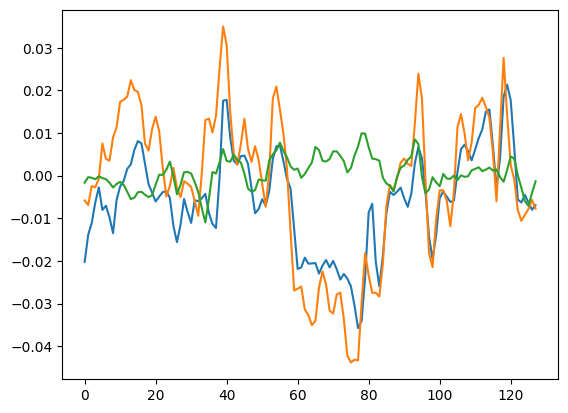


 body_gyro [bg_x, bg_y, bg_z]=f(time) for example #1


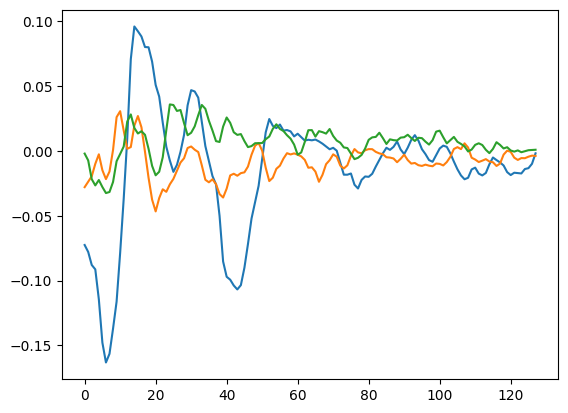


 body_gyro [bg_x, bg_y, bg_z]=f(time) for example #160


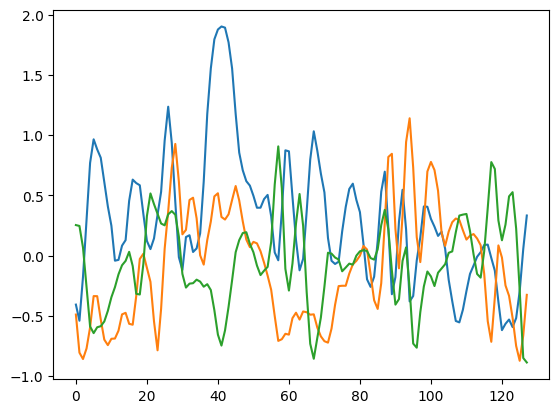


 ALL 9 channels of example #0 which has classID=LAYING


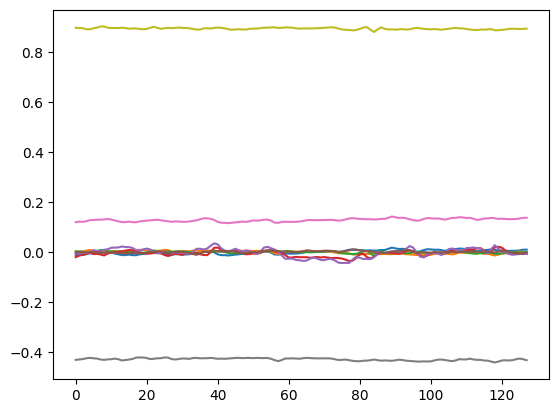


 ALL 9 channels of example #1 which has classID=STANDING


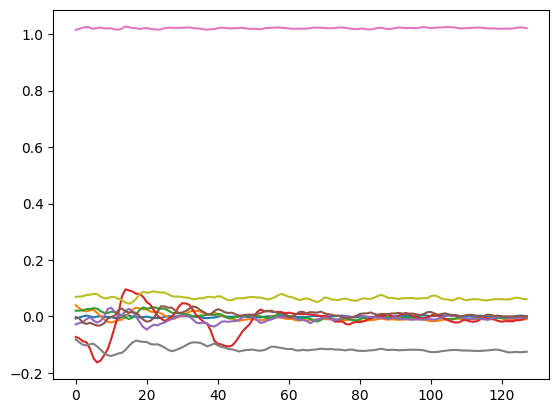


 ALL 9 channels of example #160 which has classID=WALKING UPSTAIRS


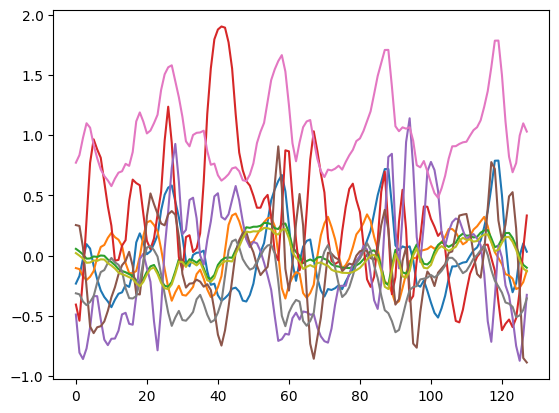

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

ex0 = tx_train_all[0].T # Transpose (for selection of body_acc variables)
ex0_body_acc = np.array([ex0[0] , ex0[1], ex0[2]])
ex0_body_acc = ex0_body_acc.T # Transpose back (for plotting)
ex0_body_gyro = np.array([ex0[3] , ex0[4], ex0[5]])
ex0_body_gyro = ex0_body_gyro.T # Transpose back (for plotting)
print("\n body acceleration [ba_x, ba_y, ba_z]=f(time) for example #0")
plt.plot(ex0_body_acc)
plt.show()

ex1 = tx_train_all[1].T # Transpose (for selection of body_acc variables))
ex1_body_acc = np.array([ex1[0] , ex1[1], ex1[2]])
ex1_body_acc = ex1_body_acc.T # Transpose back (for plotting)
ex1_body_gyro = np.array([ex1[3] , ex1[4], ex1[5]])
ex1_body_gyro = ex1_body_gyro.T # Transpose back (for plotting)
print("\n body acceleration [ba_x, ba_y, ba_z]=f(time) for example #1")
plt.plot(ex1_body_acc)
plt.show()

ex160 = tx_train_all[160].T # Transpose (for selection of body_acc variables))
ex160_body_acc = np.array([ex160[0] , ex160[1], ex160[2]])
ex160_body_acc = ex160_body_acc.T # Transpose back (for plotting)
ex160_body_gyro = np.array([ex160[3] , ex160[4], ex160[5]])
ex160_body_gyro = ex160_body_gyro.T # Transpose back (for plotting)
print("\n body acceleration [ba_x, ba_y, ba_z]=f(time) for example #160")
plt.plot(ex160_body_acc)
plt.show()

print("\n body_gyro [bg_x, bg_y, bg_z]=f(time) for example #0")
plt.plot(ex0_body_gyro)
plt.show()
print("\n body_gyro [bg_x, bg_y, bg_z]=f(time) for example #1")
plt.plot(ex1_body_gyro)
plt.show()
print("\n body_gyro [bg_x, bg_y, bg_z]=f(time) for example #160")
plt.plot(ex160_body_gyro)
plt.show()

print("\n ALL 9 channels of example #0 which has classID="+labels[target_train[0]+1])
plt.plot(tx_train_all[0])
plt.show()

print("\n ALL 9 channels of example #1 which has classID="+labels[target_train[1]+1])
plt.plot(tx_train_all[1])
plt.show()

print("\n ALL 9 channels of example #160 which has classID="+labels[target_train[160]+1])
plt.plot(tx_train_all[160])
plt.show()



### Train a LSTM Recurrent Neural Network
Below is an initial code cell for creating and training a LSTM on the data. If training becomes too long on your machine, you may want to execute rather on GoogleCOLAB.

In [10]:
#%%capture
# Note, this may take a bit to install tensorflow
!pip install -U tensorflow[and-cuda] 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 19.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 15.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.2/577.2 MB 9.1 MB/s eta 0:00:00:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 15.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.6/217.6 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 8.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━

In [ ]:
#!pip install tensorflow==2.17.1 --force-reinstall

In [30]:
import tensorflow as tf
import tensorflow.keras as tfk

print('Your tensorflow version: {}'.format(tf.__version__))
print("GPU : "+tf.test.gpu_device_name())

# Create the model architecture
model = tfk.Sequential()
nbUnits = 8
length = lengthTimeseries
model.add(tfk.layers.LSTM(units=nbUnits, activation='tanh',input_shape=(lengthTimeseries,nbTimeseries)))
model.add(tfk.layers.Dense(nbClasses, activation='softmax'))
model.summary()

# Train the model
optim = tfk.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
earlyStop = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=9)
history=model.fit(tx_train_all, target_train, validation_split=0.3, batch_size=256,
                  epochs=15, callbacks=[earlyStop])



Your tensorflow version: 2.18.0
GPU : /device:GPU:0


I0000 00:00:1731402513.004457   12682 gpu_device.cc:2022] Created device /device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 8)              │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630 (2.46 KB)

 Trainable params: 630 (2.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3151 - loss: 1.7264 - val_accuracy: 0.3935 - val_loss: 1.6745
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4337 - loss: 1.6548 - val_accuracy: 0.5267 - val_loss: 1.5843
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5415 - loss: 1.5521 - val_accuracy: 0.5562 - val_loss: 1.4891
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5449 - loss: 1.4605 - val_accuracy: 0.5168 - val_loss: 1.4066
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5114 - loss: 1.3869 - val_accuracy: 0.5136 - val_loss: 1.3383
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5155 - loss: 1.3185 - val_accuracy: 0.5490 - val_loss: 1.2852
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5585 - loss: 1.2557 - val_accuracy: 0.5607 - val_loss: 1.2359
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5595 - loss: 1.2193 - val_accuracy: 0.5671 - v

#### Display the learning curves + evaluate on test set

[INFO] evaluating network...
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.33      0.65      0.44       496
           1       0.35      0.32      0.33       471
           2       0.62      0.16      0.26       420
           3       0.77      0.79      0.78       491
           4       0.76      0.62      0.68       532
           5       1.00      0.90      0.95       537

    accuracy                           0.59      2947
   macro avg       0.64      0.57      0.57      2947
weighted avg       0.65      0.59      0.59      2947



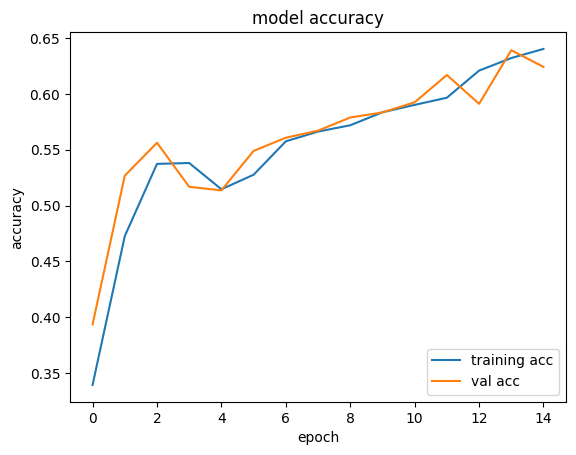

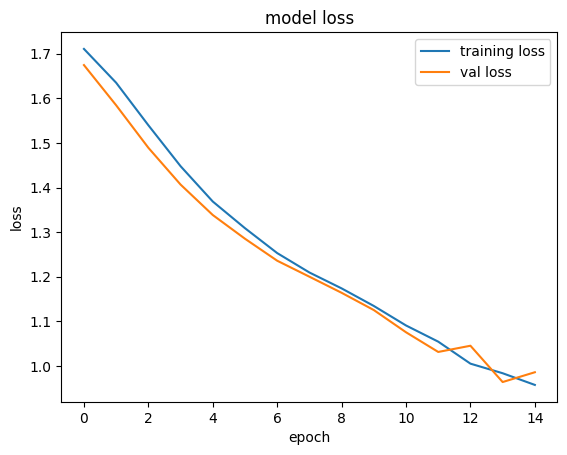

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

fig = plt.figure()
plt.plot(history.history['accuracy'],label='training acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

fig = plt.figure()
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(tx_test_all, batch_size=32)
print(classification_report(target_test, predictions.argmax(axis=1)))

**Assignment #1 : In code cell below, modify training hyper-parameters (number of LSTM units, learning rate, and number of epochs) in order to obtain better accuracy results. Ideally you should grid-search for a good combination (if training time is not too prohibitive).**

In [32]:
import tensorflow as tf
import tensorflow.keras as tfk

print('Your tensorflow version: {}'.format(tf.__version__))
print("GPU : "+tf.test.gpu_device_name())

# Create the model architecture
model = tfk.Sequential()
nbUnits = 16
length = lengthTimeseries
model.add(tfk.layers.LSTM(units=nbUnits, activation='tanh',input_shape=(lengthTimeseries,nbTimeseries)))
model.add(tfk.layers.Dense(nbClasses, activation='softmax'))
model.summary()

# Train the model
optim = tfk.optimizers.Adam(learning_rate=0.003)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
earlyStop = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=9)
history=model.fit(tx_train_all, target_train, validation_split=0.3, batch_size=64,
                  epochs=20, callbacks=[earlyStop])




Your tensorflow version: 2.18.0
GPU : /device:GPU:0


I0000 00:00:1731402528.134692   12682 gpu_device.cc:2022] Created device /device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 16)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,766 (6.90 KB)

 Trainable params: 1,766 (6.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4250 - loss: 1.5148 - val_accuracy: 0.6147 - val_loss: 1.0034
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6085 - loss: 0.9624 - val_accuracy: 0.6618 - val_loss: 0.8269
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7058 - loss: 0.7436 - val_accuracy: 0.7706 - val_loss: 0.6551
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6357 - loss: 0.9452 - val_accuracy: 0.7140 - val_loss: 0.6984
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7206 - loss: 0.6767 - val_accuracy: 0.7466 - val_loss: 0.6146
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7599 - loss: 0.5874 - val_accuracy: 0.8196 - val_loss: 0.5044
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7305 - loss: 0.6793 - val_accuracy: 0.7928 - val_loss: 0.5431
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7914 - loss: 0.5416 - val_accuracy: 0.7548 - v

[INFO] evaluating network...
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.75      0.97      0.84       496
           1       0.89      0.76      0.82       471
           2       0.97      0.88      0.92       420
           3       0.76      0.86      0.80       491
           4       0.86      0.74      0.79       532
           5       1.00      0.95      0.97       537

    accuracy                           0.86      2947
   macro avg       0.87      0.86      0.86      2947
weighted avg       0.87      0.86      0.86      2947



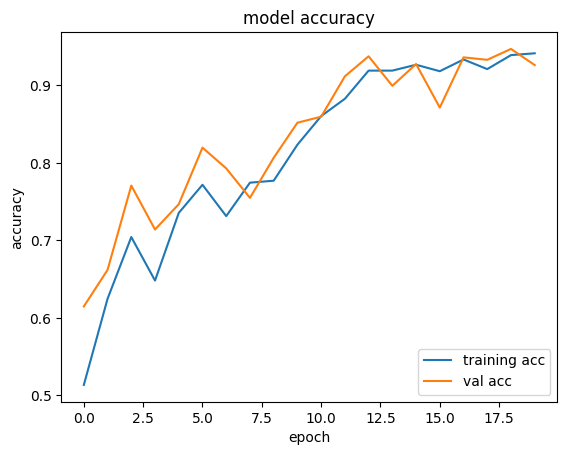

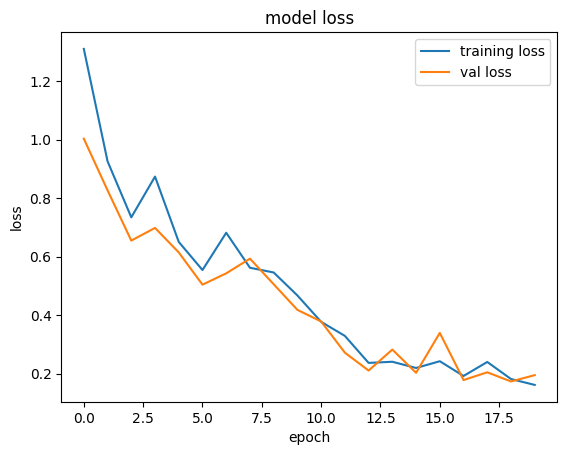

In [33]:
fig = plt.figure()
plt.plot(history.history['accuracy'],label='training acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

fig = plt.figure()
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(tx_test_all, batch_size=32)
print(classification_report(target_test, predictions.argmax(axis=1)))


**Assignment #2 : In code cell below, do the same thing but using GRU layer instead of LSTM layer**

In [34]:
# Insert below code for training on the same dataset a GRU instead of a LSTM,
#    and finding a combination of hyper-parameters producing good accuracy
import tensorflow as tf
import tensorflow.keras as tfk

print('Your tensorflow version: {}'.format(tf.__version__))
print("GPU : "+tf.test.gpu_device_name())

# Create the model architecture
model = tfk.Sequential()
nbUnits = 16
length = lengthTimeseries
model.add(tfk.layers.GRU(units=nbUnits, activation='tanh',input_shape=(lengthTimeseries,nbTimeseries)))
model.add(tfk.layers.Dense(nbClasses, activation='softmax'))
model.summary()

# Train the model
optim = tfk.optimizers.Adam(learning_rate=0.003)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
earlyStop = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=9)
history=model.fit(tx_train_all, target_train, validation_split=0.3, batch_size=64,
                  epochs=20, callbacks=[earlyStop])





Your tensorflow version: 2.18.0
GPU : /device:GPU:0


I0000 00:00:1731402609.784360   12682 gpu_device.cc:2022] Created device /device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,398 (5.46 KB)

 Trainable params: 1,398 (5.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3973 - loss: 1.6174 - val_accuracy: 0.5018 - val_loss: 1.1155
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5718 - loss: 1.0425 - val_accuracy: 0.6532 - val_loss: 0.8672
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6868 - loss: 0.8102 - val_accuracy: 0.7978 - val_loss: 0.6305
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8239 - loss: 0.5624 - val_accuracy: 0.8812 - val_loss: 0.3916
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8861 - loss: 0.3751 - val_accuracy: 0.9152 - val_loss: 0.3079
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9110 - loss: 0.2801 - val_accuracy: 0.9248 - val_loss: 0.2288
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9361 - loss: 0.1996 - val_accuracy: 0.9320 - val_loss: 0.1828
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9349 - loss: 0.1815 - val_accuracy: 0.9415 - v

# Troubleshooting

## If you get the following message "successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero" copy the following text into a file and execute that as a script